# Load in libraries/Data Sets

In [71]:
import requests
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas_datareader.data as web
import numpy as np

In [72]:
import pandas as pd
import plotly.express as px
from copy import copy
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import plotly.figure_factory as ff
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow import keras
import os

Edit tickers, target and datetime is necessary.

In [73]:
tickers = ['AAPL', 'AMZN', 'TSLA', 'GOOG', 'TWTR', '^GSPC'] 
target = ''
start = dt.datetime(2015, 1, 1)
end = dt.datetime.now()
#end = dt.datetime(2021, 1, 1)

main_df = pd.DataFrame
for ticker in tickers:
  if ticker not in target: 
    df = web.DataReader(ticker, 'yahoo', start, end)
    df = df[['Adj Close']]
    df.rename(columns={'Adj Close': ticker}, inplace=True)
    if main_df.empty: 
      main_df = df
    else: 
      main_df = main_df.join(df, how='outer')

price_df = main_df
price_df.reset_index(level=0,inplace=True)
price_df.head()

,Date,AAPL,AMZN,TSLA,GOOG,TWTR,^GSPC
0,2015-01-02,24.861401,308.519989,43.862000,523.373108,36.560001,2058.199951
1,2015-01-05,24.161013,302.190002,42.018002,512.463013,36.380001,2020.579956
2,2015-01-06,24.163294,295.290009,42.256001,500.585632,38.759998,2002.609985
3,2015-01-07,24.502111,298.420013,42.189999,499.727997,37.279999,2025.900024
4,2015-01-08,25.443539,300.459991,42.124001,501.303680,39.090000,2062.139893


In [74]:
tickers = ['AAPL', 'AMZN', 'TSLA', 'GOOG', 'TWTR', '^GSPC'] 
target = ''
start = dt.datetime(2015, 1, 1)
end = dt.datetime.now()
#end = dt.datetime(2021, 1, 1)

main_df = pd.DataFrame
for ticker in tickers:
  if ticker not in target: 
    df = web.DataReader(ticker, 'yahoo', start, end)
    df = df[['Volume']]
    df.rename(columns={'Volume': ticker}, inplace=True)
    if main_df.empty: 
      main_df = df
    else: 
      main_df = main_df.join(df, how='outer')

main_df.head()

volume_df = main_df
volume_df.reset_index(level=0, inplace=True)
volume_df.head()

,Date,AAPL,AMZN,TSLA,GOOG,TWTR,^GSPC
0,2015-01-02,212818400.0,2783200,23822000.0,1447563.0,12062500,2708700000
1,2015-01-05,257142000.0,2774200,26842500.0,2059840.0,15062700,3799120000
2,2015-01-06,263188400.0,3519000,31309500.0,2899940.0,33050800,4460110000
3,2015-01-07,160423600.0,2640300,14842000.0,2065054.0,22675700,3805480000
4,2015-01-08,237458000.0,3088400,17212500.0,3353582.0,19190400,3934010000


In [75]:
volume_df.info()
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584 entries, 0 to 1583
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1584 non-null   datetime64[ns]
 1   AAPL    1584 non-null   float64       
 2   AMZN    1584 non-null   int64         
 3   TSLA    1584 non-null   float64       
 4   GOOG    1584 non-null   float64       
 5   TWTR    1584 non-null   int64         
 6   ^GSPC   1584 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 86.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584 entries, 0 to 1583
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1584 non-null   datetime64[ns]
 1   AAPL    1584 non-null   float64       
 2   AMZN    1584 non-null   float64       
 3   TSLA    1584 non-null   float64       
 4   GOOG    1584 non-null   float64       
 5   TWTR    1

## Load in average daily sentiment for AMZN 

In [76]:
sent_df = pd.read_csv('AMZN_avg_sent.csv',error_bad_lines=False)
sent_df = sent_df.rename(columns={'date': 'Date'})
sent_df['Date'] = pd.to_datetime(sent_df['Date'])
sent_df.head()

,Date,sent
0,2015-01-01,-0.091088
1,2015-01-02,0.026933
2,2015-01-03,0.047103
3,2015-01-04,0.054920
4,2015-01-05,0.042016


# Ridge Regression
Predict future price using previous prices and volume


Ridge Regression works by avoiding overfitting and helps by adjusting weights or biases to improve generalization 

## Helper Functions

In [77]:
# Function to normalize stock prices based on their initial price
def normalize(df):
  x = df.copy()
  for i in x.columns[1:]:
    x[i] = x[i]/x[i][0]
  return x


In [78]:
# Function to return the input/output (target) data for AI/ML Model
# Note that our goal is to predict the future stock price 
# Target stock price today will be tomorrow's price 
def trading_window(data):
  
  # 1 day window 
  n = 1

  # Create a column containing the prices for the next 1 days
  data['Target'] = data[['Close']].shift(-n)
  
  # return the new dataset 
  return data

In [79]:
# Function to concatenate the date, stock price, and volume in one dataframe
def individual_stock(price_df, vol_df, name):
    return pd.DataFrame({'Date': price_df['Date'], 'Close': price_df[name], 'Volume': vol_df[name]})

## Regression based on Previous Day Trade Volume and Prices

#### Creating Data Frame

In [80]:
price_volume_df = individual_stock(price_df, volume_df, 'AMZN')

In [81]:
price_volume_target_df = trading_window(price_volume_df)
price_volume_target_df = price_volume_target_df[:-1] # Remove the last row as it will be a null value
price_volume_target_df

#Target is next days price.

,Date,Close,Volume,Target
0,2015-01-02,308.519989,2783200,302.190002
1,2015-01-05,302.190002,2774200,295.290009
2,2015-01-06,295.290009,3519000,298.420013
3,2015-01-07,298.420013,2640300,300.459991
4,2015-01-08,300.459991,3088400,296.929993
...,...,...,...,...
1578,2021-04-12,3379.389893,3281800,3400.000000
1579,2021-04-13,3400.000000,3315800,3333.000000
1580,2021-04-14,3333.000000,3145200,3379.090088
1581,2021-04-15,3379.090088,3233600,3399.439941


#### Spliting

In [82]:
# Scale the data
# Scale the data is 
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))

price_volume_target_scaled_df = sc.fit_transform(price_volume_target_df.drop(columns = ['Date']))


# Creating Feature and Target
X = price_volume_target_scaled_df[:,:2]  #features are x 
y = price_volume_target_scaled_df[:,2:]  #target are y 


#80% of data is used for training other 20% is used for testing
split = int(0.8 * len(X))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]



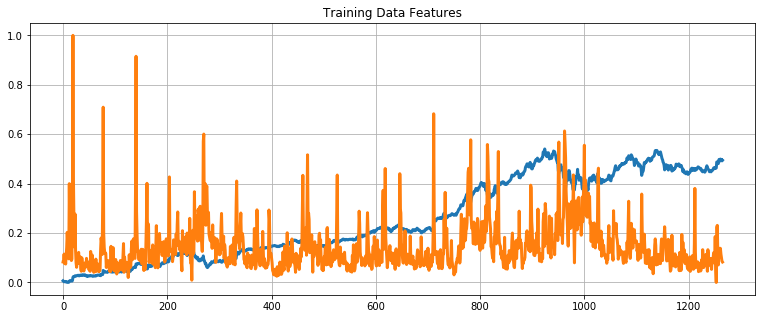

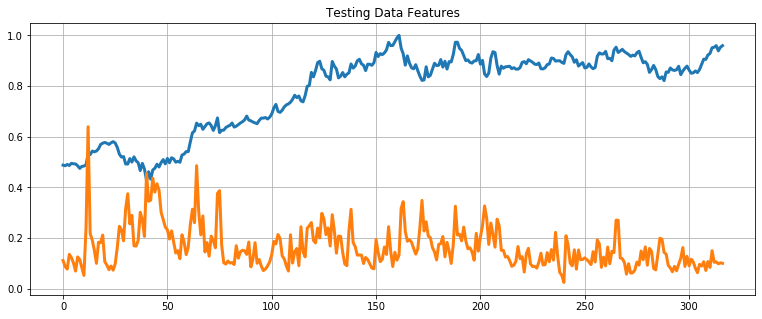

In [83]:
# Define a data plotting function
def show_plot(data, title):
  plt.figure(figsize = (13, 5))
  plt.plot(data, linewidth = 3)
  plt.title(title)
  plt.grid()

show_plot(X_train, 'Training Data Features')
show_plot(X_test, 'Testing Data Features')

#Blue is Price, Orange is Trading Volume




### Running the Model

In [84]:
from sklearn.linear_model import Ridge
# Note that Ridge regression performs linear least squares with L2 regularization.
# Create and train the Ridge Linear Regression  Model
regression_model = Ridge()
regression_model.fit(X_train, y_train)

# Test the model and calculate its accuracy 
lr_accuracy = regression_model.score(X_test, y_test)
print("Linear Regression Score: ", lr_accuracy)

Linear Regression Score:  0.9744799325954596


In [85]:
# Make Prediction
predicted_prices = regression_model.predict(X)

# Append the predicted values into a list
Predicted = []
for i in predicted_prices:
  Predicted.append(i[0])


# Append the close values to the list
close = []
for i in price_volume_target_scaled_df:
  close.append(i[0])

len(Predicted)

1583

In [86]:
# Create a dataframe based on the dates in the individual stock data
df_predicted = price_volume_target_df[['Date']]
df_predicted

,Date
0,2015-01-02
1,2015-01-05
2,2015-01-06
3,2015-01-07
4,2015-01-08
...,...
1578,2021-04-12
1579,2021-04-13
1580,2021-04-14
1581,2021-04-15


In [87]:
# Add the close values to the dataframe
df_predicted['Close'] = close
df_predicted

,Date,Close
0,2015-01-02,0.006648
1,2015-01-05,0.004697
2,2015-01-06,0.002571
3,2015-01-07,0.003535
4,2015-01-08,0.004164
...,...,...
1578,2021-04-12,0.953133
1579,2021-04-13,0.959485
1580,2021-04-14,0.938835
1581,2021-04-15,0.953041


In [88]:
# Add the predicted values to the dataframe
df_predicted['Prediction'] = Predicted
df_predicted

,Date,Close,Prediction
0,2015-01-02,0.006648,0.014206
1,2015-01-05,0.004697,0.012311
2,2015-01-06,0.002571,0.010363
3,2015-01-07,0.003535,0.011163
4,2015-01-08,0.004164,0.011843
...,...,...,...
1578,2021-04-12,0.953133,0.932780
1579,2021-04-13,0.959485,0.938950
1580,2021-04-14,0.938835,0.918884
1581,2021-04-15,0.953041,0.932683


In [89]:
# Plot the results
#df_predicted, "Original Vs. Prediction")

df_predicted.set_index('Date')
df_predicted


,Date,Close,Prediction
0,2015-01-02,0.006648,0.014206
1,2015-01-05,0.004697,0.012311
2,2015-01-06,0.002571,0.010363
3,2015-01-07,0.003535,0.011163
4,2015-01-08,0.004164,0.011843
...,...,...,...
1578,2021-04-12,0.953133,0.932780
1579,2021-04-13,0.959485,0.938950
1580,2021-04-14,0.938835,0.918884
1581,2021-04-15,0.953041,0.932683


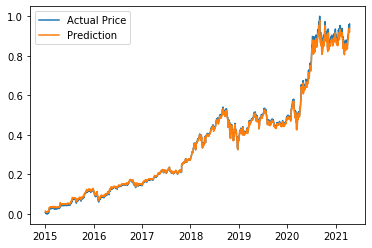

In [90]:
plt.plot(df_predicted['Date'],df_predicted['Close'], label = "Actual Price")
plt.plot(df_predicted['Date'],df_predicted['Prediction'], label = 'Prediction')


plt.legend()

plt.show()



## Regression based on Previous Day Trade Volume,Prices and Average Sentiment

#### Creating Data Frame

In [91]:
#MERGE DF FROM SENTIMENT AND STOCK DATA
sent_price_volume_df = pd.merge(price_volume_df,sent_df, on = 'Date')
sent_price_volume_df = trading_window(sent_price_volume_df)
sent_price_volume_df = sent_price_volume_df[:-1]
sent_price_volume_df = sent_price_volume_df[['Date','Close','Volume','sent','Target']]
sent_price_volume_df

,Date,Close,Volume,sent,Target
0,2015-01-02,308.519989,2783200,0.026933,302.190002
1,2015-01-05,302.190002,2774200,0.042016,295.290009
2,2015-01-06,295.290009,3519000,0.044505,298.420013
3,2015-01-07,298.420013,2640300,0.047204,300.459991
4,2015-01-08,300.459991,3088400,0.050522,296.929993
...,...,...,...,...,...
1252,2019-12-23,1793.000000,2136400,0.043664,1789.209961
1253,2019-12-24,1789.209961,881300,0.081276,1868.770020
1254,2019-12-26,1868.770020,6005400,0.110226,1869.800049
1255,2019-12-27,1869.800049,6186600,0.095547,1846.890015


#### Spliting

In [92]:
#sentiment normalzing data to scale
sent_price_volume_scaled_df = sc.fit_transform(sent_price_volume_df.drop(columns = ['Date']))

#Feature and Target for Sentiment
X2 = sent_price_volume_scaled_df[:,:3]  #features are x 
y2 = sent_price_volume_scaled_df[:,3:]  #target are y 



#Sentiment #80% of data is used for training other 20% is used for testing
split2 = int(0.8 * len(X2))
X2_train = X2[:split2]
y2_train = y2[:split2]
X2_test = X2[split2:]
y2_test = y2[split2:]

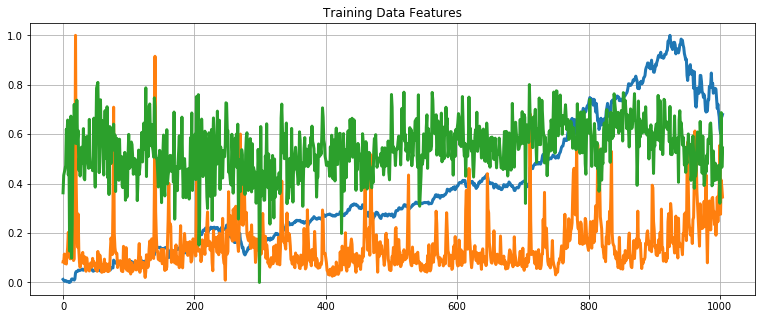

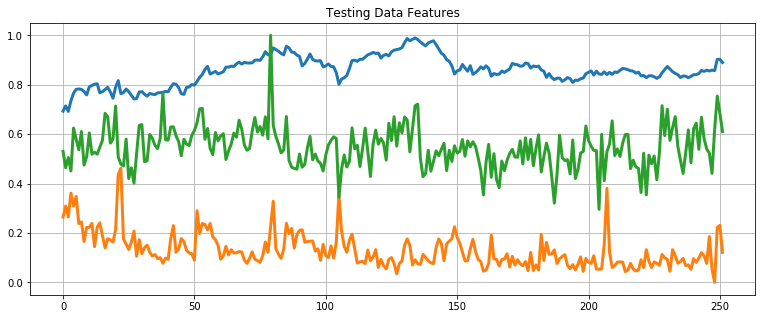

In [93]:
# Define a data plotting function for Sentiment
def show_plot(data, title):
  plt.figure(figsize = (13, 5))
  plt.plot(data, linewidth = 3)
  plt.title(title)
  plt.grid()

show_plot(X2_train, 'Training Data Features')
#show_plot(X2_train[:,2],'Sentiment')
#show_plot(X2_train[:,1],'Trading Volume')
#show_plot(X2_train[:,0],'Close')
show_plot(X2_test, 'Testing Data Features')


#Green is sentiment, Blue is Close, Orange is Trading Volume



### Running the Model

In [94]:
#Sentiment model
sentimentregression_model = Ridge()
sentimentregression_model.fit(X2_train, y2_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [95]:
#Sentiment model
lr_accuracy = sentimentregression_model.score(X2_test, y2_test)
print("Linear Regression Score: ", lr_accuracy)

Linear Regression Score:  0.912496672124599


In [96]:
#Sentiment model
sentimentpredicted_prices = sentimentregression_model.predict(X2)

In [97]:
#Sentiment model
SentimentPredicted = []
for i in sentimentpredicted_prices:
  SentimentPredicted.append(i[0])

len(SentimentPredicted)

1257

In [98]:
#Sentiment model
sentimentclose = []
for i in sent_price_volume_scaled_df:
  sentimentclose.append(i[0])

In [99]:
sentdf_predicted = sent_price_volume_df[['Date']]

In [100]:
sentdf_predicted['Close'] = sentimentclose

In [101]:
#Sentiment
# Plot the results
#df_predicted, "Original Vs. Prediction")


sentdf_predicted['Prediction'] = SentimentPredicted
sentdf_predicted.set_index('Date')
sentdf_predicted

,Date,Close,Prediction
0,2015-01-02,0.012308,0.015177
1,2015-01-05,0.008696,0.013431
2,2015-01-06,0.004759,0.010083
3,2015-01-07,0.006545,0.011901
4,2015-01-08,0.007709,0.013568
...,...,...,...
1252,2019-12-23,0.859343,0.847425
1253,2019-12-24,0.857180,0.849424
1254,2019-12-26,0.902577,0.898867
1255,2019-12-27,0.903165,0.897746


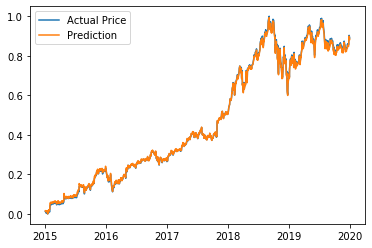

In [102]:
plt.plot(sentdf_predicted['Date'],sentdf_predicted['Close'], label = "Actual Price")
plt.plot(sentdf_predicted['Date'],sentdf_predicted['Prediction'], label = 'Prediction')


plt.legend()
plt.show()


# RESULTS

In [103]:
lr_accuracy = regression_model.score(X_test, y_test)
print("Ridge Regression Score: ", lr_accuracy)
#Sentiment model
sentlr_accuracy = sentimentregression_model.score(X2_test, y2_test)
print("Ridge Regression Score using Sentiment: ", sentlr_accuracy)

Ridge Regression Score:  0.9744799325954596
Ridge Regression Score using Sentiment:  0.912496672124599


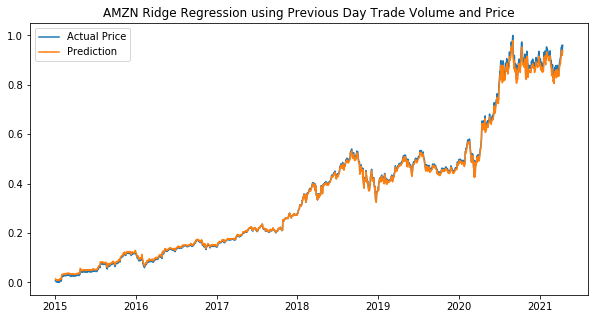

In [110]:
plt.figure(figsize=(10, 5))
plt.plot(df_predicted['Date'],df_predicted['Close'], label = "Actual Price")
plt.plot(df_predicted['Date'],df_predicted['Prediction'], label = 'Prediction')


plt.legend()
plt.title('AMZN Ridge Regression using Previous Day Trade Volume and Price')
plt.show()


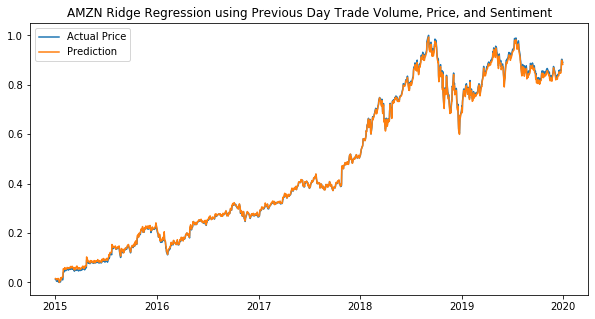

In [105]:
plt.figure(figsize=(10, 5))
plt.plot(sentdf_predicted['Date'],sentdf_predicted['Close'], label = "Actual Price")
plt.plot(sentdf_predicted['Date'],sentdf_predicted['Prediction'], label = 'Prediction')


plt.legend()
plt.title('AMZN Ridge Regression using Previous Day Trade Volume, Price, and Sentiment')
plt.show()


In [137]:
sentbinary = sentdf_predicted.set_index('Date').diff()
binary = df_predicted.set_index('Date').diff()

In [141]:
sentbinary["Prediction Change"] = np.where(sentbinary["Prediction"] < 0, 0,1)
sentbinary["Actual Change"] = np.where(sentbinary["Close"] < 0, 0,1)
sentbinary["Correct Guesses for Sentiment"] = np.where(sentbinary["Prediction Change"] == sentbinary["Actual Change"], 1,0)


binary["Prediction Change"] = np.where(binary["Prediction"] < 0, 0,1)
binary["Actual Change"] = np.where(binary["Close"] < 0, 0,1)
binary["Correct Guesses Normal"] = np.where(binary["Prediction Change"] == binary["Actual Change"], 1,0)

In [142]:
sentbinary

,Close,Prediction,PredictionChange,Prediction Change,Actual Change,Correct Guesses for Sentiment
Date,,,,,,
2015-01-02,NaN,NaN,NaN,1,1,1
2015-01-05,-0.003612,-0.001746,0.0,0,0,1
2015-01-06,-0.003937,-0.003347,0.0,0,0,1
2015-01-07,0.001786,0.001818,0.0,1,1,1
2015-01-08,0.001164,0.001667,0.0,1,1,1
...,...,...,...,...,...,...
2019-12-23,0.003709,0.000700,0.0,1,1,1
2019-12-24,-0.002163,0.001999,0.0,1,0,0
2019-12-26,0.045396,0.049443,0.0,1,1,1


In [143]:
binary

,Close,Prediction,Prediction Change,Actual Change,Correct Guesses for Sentiment,Correct Guesses Normal
Date,,,,,,
2015-01-02,NaN,NaN,1,1,1,1
2015-01-05,-0.001951,-0.001895,0,0,1,1
2015-01-06,-0.002127,-0.001948,0,0,1,1
2015-01-07,0.000965,0.000800,1,1,1,1
2015-01-08,0.000629,0.000680,1,1,1,1
...,...,...,...,...,...,...
2021-04-12,0.002216,0.001987,1,1,1,1
2021-04-13,0.006352,0.006170,1,1,1,1
2021-04-14,-0.020650,-0.020066,0,0,1,1


In [146]:

binary['Correct Guesses Normal'].value_counts()

1    1558
0      25
Name: Correct Guesses Normal, dtype: int64

In [144]:
sentbinary['Correct Guesses for Sentiment'].value_counts()

1    1100
0     157
Name: Correct Guesses for Sentiment, dtype: int64

# Model LSTM Time series Model
### LSTM uses neural networks to extrapolate to learn from long term dependencies

Collects information given different weights into a neuron to give a output. It is a multi-layer perceptron network that lets us use different weights.
By training over and over again, the model gets more and more efficient 

Recurrent Neural Networks uses feedback loops to help predict future events

In [147]:
sent_price_volume_df

,Date,Close,Volume,sent,Target
0,2015-01-02,308.519989,2783200,0.026933,302.190002
1,2015-01-05,302.190002,2774200,0.042016,295.290009
2,2015-01-06,295.290009,3519000,0.044505,298.420013
3,2015-01-07,298.420013,2640300,0.047204,300.459991
4,2015-01-08,300.459991,3088400,0.050522,296.929993
...,...,...,...,...,...
1252,2019-12-23,1793.000000,2136400,0.043664,1789.209961
1253,2019-12-24,1789.209961,881300,0.081276,1868.770020
1254,2019-12-26,1868.770020,6005400,0.110226,1869.800049
1255,2019-12-27,1869.800049,6186600,0.095547,1846.890015


In [148]:
#Get training data (Inputs)
training_data = sent_price_volume_df.iloc[:,1:4].values
training_data

array([[3.08519989e+02, 2.78320000e+06, 2.69325150e-02],
       [3.02190002e+02, 2.77420000e+06, 4.20156250e-02],
       [2.95290009e+02, 3.51900000e+06, 4.45051020e-02],
       ...,
       [1.86877002e+03, 6.00540000e+06, 1.10226087e-01],
       [1.86980005e+03, 6.18660000e+06, 9.55474140e-02],
       [1.84689001e+03, 3.67470000e+06, 7.96374270e-02]])

In [149]:
#Scale the data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled = sc.fit_transform(training_data)

In [150]:
#Creating the training and testing data in which training data utilizes pressent day and previous day values
X = []
y = []
for i in range(1, len(sent_price_volume_df)):
    X.append(training_set_scaled [i-1:i, 0])
    y.append(training_set_scaled [i, 0])

X

[array([0.0123077]),
 array([0.00869585]),
 array([0.00475875]),
 array([0.00654471]),
 array([0.00770871]),
 array([0.00569452]),
 array([0.00254484]),
 array([0.00444491]),
 array([0.00360614]),
 array([0.]),
 array([0.00216254]),
 array([0.00142077]),
 array([0.00587711]),
 array([0.01333478]),
 array([0.01451591]),
 array([0.01295818]),
 array([0.01129775]),
 array([0.00967727]),
 array([0.01416784]),
 array([0.03856073]),
 array([0.04423243]),
 array([0.04370748]),
 array([0.0443922]),
 array([0.04960743]),
 array([0.04982996]),
 array([0.04770735]),
 array([0.0490996]),
 array([0.05032068]),
 array([0.05147898]),
 array([0.05413793]),
 array([0.05048613]),
 array([0.04931071]),
 array([0.05252316]),
 array([0.05518213]),
 array([0.05317364]),
 array([0.05228921]),
 array([0.05615784]),
 array([0.0558326]),
 array([0.05318505]),
 array([0.05632332]),
 array([0.05572418]),
 array([0.05464577]),
 array([0.0575615]),
 array([0.0531451]),
 array([0.0522721]),
 array([0.04710823]),
 ar

In [151]:
    
    
X = np.asarray(X)
y = np.asarray(y)

In [152]:
# Split the data
split = int(0.7 * len(X))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

In [153]:
# Reshape the 1D arrays to 3D arrays to feed in the model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_train.shape, X_test.shape

((879, 1, 1), (377, 1, 1))

In [154]:
#Making the model
inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = keras.layers.LSTM(150, return_sequences= True)(inputs)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150, return_sequences=True)(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150)(x)
outputs = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss="mse")
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1)]            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 150)            91200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 150)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 150)            180600    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 150)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151 

In [155]:
# Training the model
history = model.fit(
    X_train, y_train,
    epochs = 20,
    batch_size = 32,
    validation_split = 0.2
)

Epoch 1/20
22/22 [==============================] - 5s 45ms/step - loss: 0.0467 - val_loss: 0.0802
Epoch 2/20
22/22 [==============================] - 0s 7ms/step - loss: 0.0124 - val_loss: 0.1198
Epoch 3/20
22/22 [==============================] - 0s 9ms/step - loss: 0.0072 - val_loss: 0.0518
Epoch 4/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0030 - val_loss: 9.7181e-04
Epoch 5/20
22/22 [==============================] - 0s 7ms/step - loss: 3.9776e-04 - val_loss: 0.0034
Epoch 6/20
22/22 [==============================] - 0s 7ms/step - loss: 3.5306e-04 - val_loss: 4.6019e-04
Epoch 7/20
22/22 [==============================] - 0s 7ms/step - loss: 3.2011e-04 - val_loss: 0.0019
Epoch 8/20
22/22 [==============================] - 0s 7ms/step - loss: 2.8190e-04 - val_loss: 6.6305e-04
Epoch 9/20
22/22 [==============================] - 0s 7ms/step - loss: 2.9391e-04 - val_loss: 6.6158e-04
Epoch 10/20
22/22 [==============================] - 0s 7ms/step - loss: 2.2523e-

In [156]:
# Make prediction
predicted = model.predict(X)

In [157]:
# Append the predicted values to the list
test_predicted = []

for i in predicted:
  test_predicted.append(i[0])

In [158]:
df_predicted = sent_price_volume_df[1:][['Date','Close']]
df_predicted

,Date,Close
1,2015-01-05,302.190002
2,2015-01-06,295.290009
3,2015-01-07,298.420013
4,2015-01-08,300.459991
5,2015-01-09,296.929993
...,...,...
1252,2019-12-23,1793.000000
1253,2019-12-24,1789.209961
1254,2019-12-26,1868.770020
1255,2019-12-27,1869.800049


In [159]:
df_predicted['Prediction'] = test_predicted

In [160]:
# Plot the data
close = []
for i in training_set_scaled:
  close.append(i[0])


In [161]:
df_predicted['Close'] = close[1:]

In [162]:
df_predicted

,Date,Close,Prediction
1,2015-01-05,0.008696,0.016508
2,2015-01-06,0.004759,0.012976
3,2015-01-07,0.006545,0.009130
4,2015-01-08,0.007709,0.010874
5,2015-01-09,0.005695,0.012012
...,...,...,...
1252,2019-12-23,0.859343,0.881510
1253,2019-12-24,0.857180,0.885370
1254,2019-12-26,0.902577,0.883120
1255,2019-12-27,0.903165,0.930317


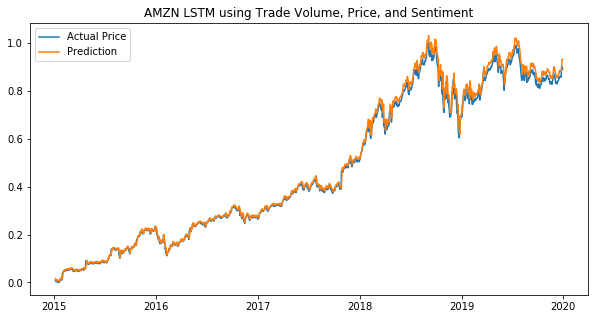

In [163]:
plt.figure(figsize=(10, 5))
plt.plot(df_predicted['Date'],df_predicted['Close'], label = "Actual Price")
plt.plot(df_predicted['Date'],df_predicted['Prediction'], label = 'Prediction')


plt.legend()
plt.title('AMZN LSTM using Trade Volume, Price, and Sentiment')
plt.show()

In [165]:
df_predicted
binary = df_predicted.set_index('Date').diff()
binary["Prediction Change"] = np.where(binary["Prediction"] < 0, 0,1)
binary["Actual Change"] = np.where(binary["Close"] < 0, 0,1)
binary["Correct Guesses LSTM"] = np.where(binary["Prediction Change"] == binary["Actual Change"], 1,0)
binary['Correct Guesses LSTM'].value_counts()

1    650
0    606
Name: Correct Guesses LSTM, dtype: int64